# GENERAR GIF EVOLUCIÓN URBANÍSTICA

Gracias a este script podrás generar un gif con la evolución urbanística de un área geográfica determinada.

Para ello solo tienes que ejecutar todas las celdas en orden y subir varias imágenes satelitales del área de la que deseas conocer su evolución en diferentes en diferentes épocas.

Finalmente podrás descargar el gif resultado.
Código de colores:
-	Verde: edificios de la primera imágen o que ya estaban identificados en la imagen previa.
-	Azul: nuevos edificios en cada una de las imágenes.
-	Rojo: edificios que desaparecen de una imagen a la siguiente.

In [1]:
# @title Intalar e importar librerias
!pip install transformers==4.27.1

import numpy as np
from PIL import Image, ImageDraw, ImageOps
import imageio
import tensorflow as tf
import pandas as pd

import os
import cv2
import torch
import torchvision

from torch.optim import AdamW
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from torch import load, nn

import requests
from io import BytesIO
from scipy.ndimage import label

from IPython.display import Image as IPImage
from IPython.display import display

from google.colab import files
from ipywidgets import Button, Layout

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.4 MB/s eta 0:00:00


In [2]:
# @title Descarga y carga del modelo preentrenado

# Enlace de descarga directa de Dropbox
# url = "https://dl.dropboxusercontent.com/scl/fi/upywaddunnqr1pv4n2tm6/best_model.pth?rlkey=6980bkytyn4z49ztgl2pgjh7u&dl=1"
url = "https://dl.dropboxusercontent.com/scl/fi/08kjsqg6nvgsroy6z7896/best_model_2.pth?rlkey=7247zev4zfdxq98pq0m2n8beh&dl=1"

# Descargar los pesos del modelo
response = requests.get(url)
if response.status_code == 200:
    with open('modelo_descargado.pth', 'wb') as f:
        f.write(response.content)

# CSV con las clases a identificar
data = {
    'name': ['unlabeled', 'building'],
    'r': [0, 1],
    'g': [0, 1],
    'b': [0, 1]
}

# Creamos un DataFrame con los datos
df = pd.DataFrame(data)

classes = df['name']
palette = df[['r', 'g', 'b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}


# Carga del modelo preentrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label),
                                                         id2label=id2label,
                                                         label2id=label2id,
                                                         reshape_last_stage=True)

if torch.cuda.is_available():
    checkpoint = torch.load('modelo_descargado.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    checkpoint = torch.load('modelo_descargado.pth', map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

(…)o/nvidia/mit-b5/resolve/main/config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [3]:
# @title Cargar los métodos para realizar el procesado

# Modificamos la función divide_image para rellenar las imágenes al tamaño deseado
def divide_image(image, block_size=(1000, 1000)):
    w, h = image.size
    blocks = []
    for i in range(0, h, block_size[1]):
        for j in range(0, w, block_size[0]):
            box = (j, i, j + block_size[0], i + block_size[1])
            block = image.crop(box)
            if block.size[0] < block_size[0] or block.size[1] < block_size[1]:
                block = block.resize(block_size, Image.ANTIALIAS)
            blocks.append(block)
    return blocks


def recompose_image(pieces, original_size, block_size=(1000, 1000), is_mask=False):
    """
    Recompone las porciones de la imagen o máscara en una imagen del tamaño original.
    """
    new_image = Image.new('RGB' if not is_mask else 'L', original_size)
    i = 0
    piece_width, piece_height = block_size
    for y in range(0, original_size[1], piece_height):
        for x in range(0, original_size[0], piece_width):
            block = pieces[i]
            if isinstance(block, np.ndarray):
                # Convertimos el bloque a un tipo de datos que Image.fromarray pueda manejar
                if block.dtype != np.uint8:
                    block = block.astype(np.uint8)
                block = Image.fromarray(block)
            if block.size != block_size:
                # Rellena la pieza si es más pequeña que el tamaño del bloque
                block = ImageOps.pad(block, block_size, method=Image.LANCZOS, color=(0, 0, 0) if not is_mask else 0)
            new_image.paste(block, (x, y))
            i += 1
    return new_image


# Función con la que predecimos las máscaras
def predict_mask(image, model, device='cuda'):
    """
    Devuelve la máscara predicha para una imagen.
    """
    feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits.cpu()
        upsampled_logits = nn.functional.interpolate(logits,
                        size=image.size[::-1],  # Tamaño original de la imagen
                        mode='bilinear',
                        align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)[0]

    return predicted.detach().cpu().numpy()

from scipy.ndimage import label


def generate_gif_overlay(images_list, masks_list, output_filename='image_overlay'):
    """
    Genera un GIF con la imagen original y la máscara superpuesta
    """
    overlay_frames = []
    mask_frames = []

    for img, mask in zip(images_list, masks_list):
        # Convertir la máscara a un array de NumPy si es necesario
        if isinstance(mask, Image.Image):
            mask = np.array(mask)

        # Crear overlay para el GIF con imágenes superpuestas
        overlay = np.zeros((*mask.shape, 3), dtype=np.uint8)
        overlay[mask == 1] = [0, 255, 0]  # Color verde para la máscara

        combined_image = np.array(img) * 0.5 + overlay * 0.5
        combined_image = combined_image.astype(np.uint8)
        overlay_frames.append(Image.fromarray(combined_image))

        # Crear imagen de máscara binaria para el segundo GIF
        # binary_mask_image = (mask * 255).astype(np.uint8)  # Convertir a escala de grises
        # mask_frames.append(Image.fromarray(binary_mask_image, mode='L'))

    imageio.mimsave(f'{output_filename}.gif', overlay_frames, duration=1000, loop=0)
    # imageio.mimsave(f'{output_filename}_binary_masks.gif', mask_frames, duration=1000, loop=0)



def generate_evolution_gif(masks_list, output_filename='urban_evolution'):
    """
    A partir de las máscaras obtenidas se crea un GIF donde se muestra la evolución entre máscaras sucesivas.
    """
    evolution_frames = []
    prev_labels = None

    for i, mask in enumerate(masks_list):
        # Convertir la máscara a un array de NumPy si es necesario
        if isinstance(mask, Image.Image):
            mask = np.array(mask)

        # Etiquetar las características en la máscara actual
        mask_array = mask > 0.5  # Esto crea una máscara binaria
        labeled_mask, num_features = label(mask_array)

        # Inicializar la imagen de la máscara de evolución
        evolution_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

        # Recorrer todas las características etiquetadas en la máscara actual
        if i == 0:  # Comprobar si es la primera máscara para colorearla de verde
            evolution_mask[mask_array] = [0, 255, 0]  # Verde
        else:
            for feature_id in range(1, num_features + 1):
                feature_mask = labeled_mask == feature_id
                if prev_labels is not None and np.any(prev_labels[feature_mask]):
                    # Si la característica estaba en la máscara anterior, se mantiene su color (blanco/verde)
                    evolution_mask[feature_mask] = [0, 255, 0]  # Verde
                else:
                    # Si la característica es nueva, se colorea de azul
                    evolution_mask[feature_mask] = [0, 0, 255]  # Azul

            # Identificar características que desaparecieron
            if prev_labels is not None:
                for prev_feature_id in np.unique(prev_labels):
                    if prev_feature_id != 0 and not np.any(labeled_mask[prev_labels == prev_feature_id]):
                        # Si la característica anterior no está en la máscara actual, se colorea de rojo
                        evolution_mask[prev_labels == prev_feature_id] = [255, 0, 0]  # Rojo

        # Actualizar la máscara anterior con la actual
        prev_labels = labeled_mask

        # Agregar la imagen coloreada a la lista de frames
        evolution_frames.append(Image.fromarray(evolution_mask))

    # Guardar el GIF
    imageio.mimsave(f'{output_filename}.gif', evolution_frames, duration=1000, loop=0)

    # Imprimir GIF
    with open(f'{output_filename}.gif', 'rb') as f:
        display(IPImage(data=f.read(), format='png'))


In [4]:
# @title Subir imágenes, puedes elegir varias a la vez

image_paths = []
images_list = []

# Función para cargar archivos desde tu sistema
uploaded = files.upload()

# Guardar los archivos subidos y abrir las imágenes
for filename in uploaded.keys():
    # Guardar cada archivo subido al entorno de Colab
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    image_paths.append(filename)  # Añadir la ruta del archivo a la lista

# Ordenar las rutas de archivos en orden alfabético
image_paths.sort()

# Una vez guardados, puedes cargar las imágenes en una lista
images_list = [Image.open(path) for path in image_paths]

Saving pueblo00023.jpg to pueblo00023.jpg
Saving pueblo00018.jpg to pueblo00018.jpg
Saving pueblo00011.jpg to pueblo00011.jpg
Saving pueblo00003.jpg to pueblo00003.jpg


Imagen 1: 271 edificios detectados.
Imagen 2: 404 edificios detectados.
Imagen 3: 493 edificios detectados.
Imagen 4: 576 edificios detectados.


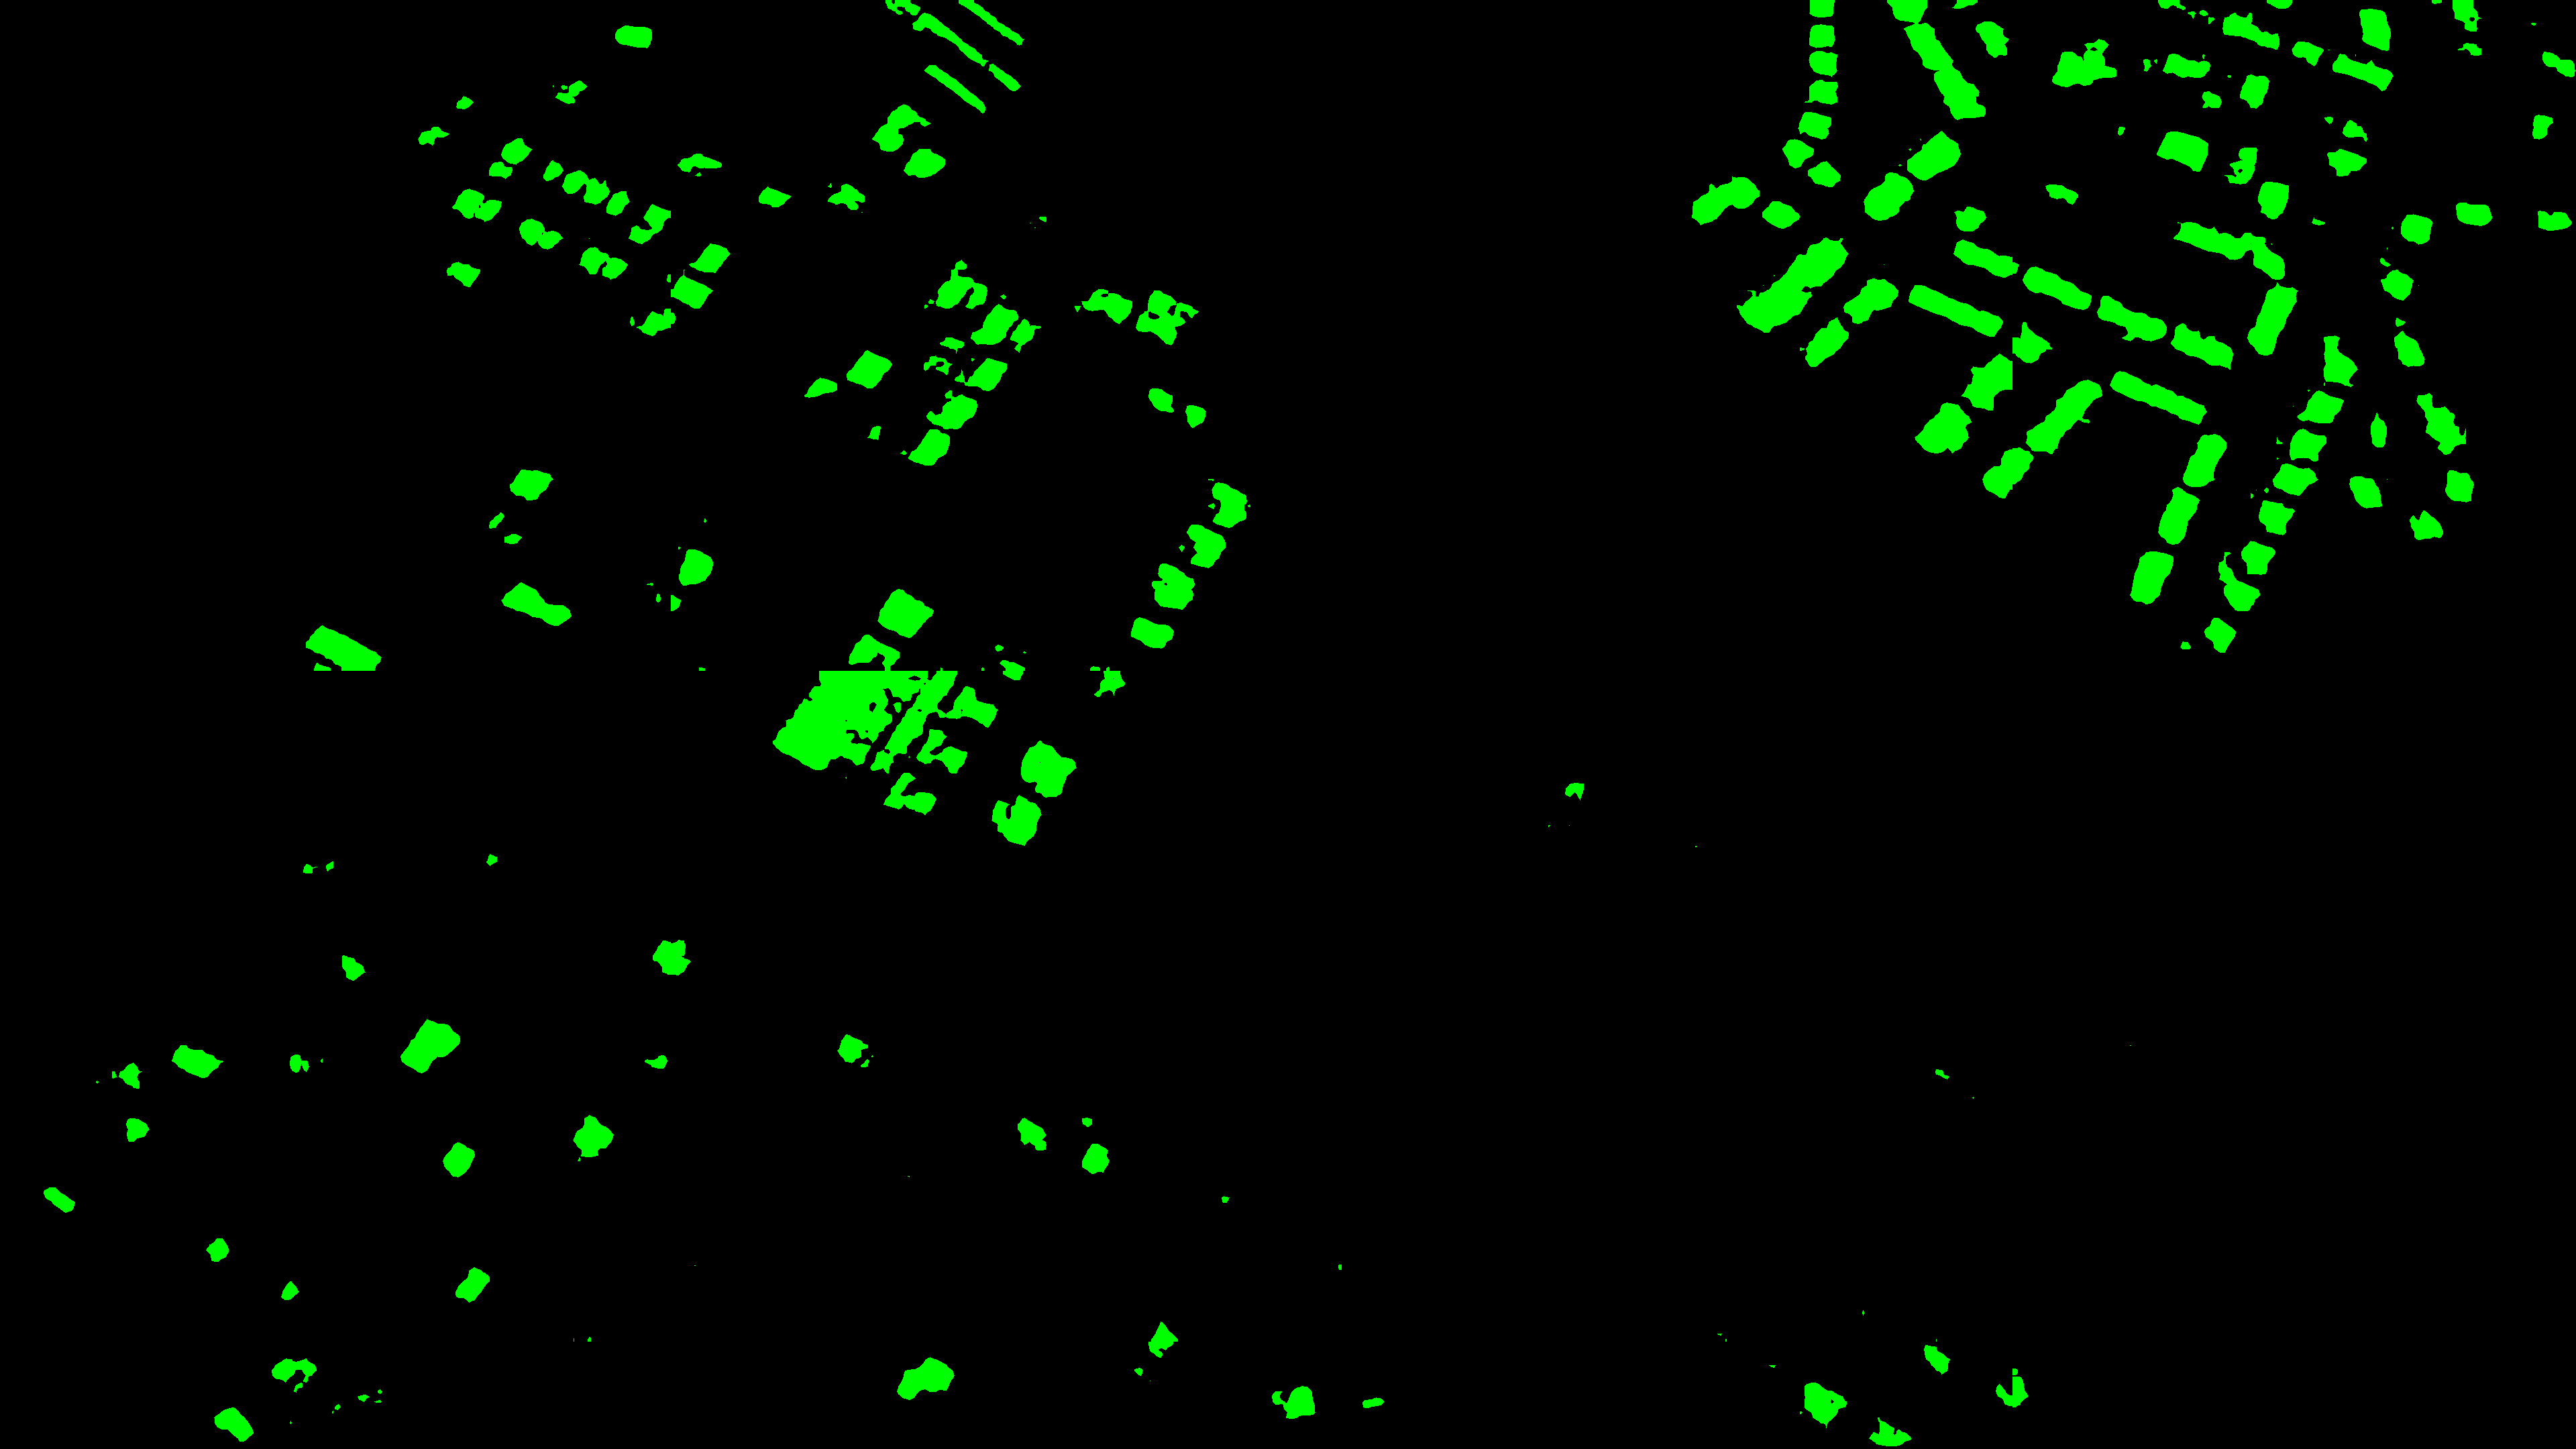

In [6]:
# @title Ejecutar instrucciones

processed_images = []
processed_masks = []

# Dividimos las imágenes en porciones más pequeñas para facilitar la identificación de elementos
for image in images_list:
    pieces = divide_image(image)
    mask_pieces = []

    for piece in pieces:
        mask_piece = predict_mask(piece, model, device)
        mask_pieces.append(mask_piece)

    recomposed_image = recompose_image(pieces, image.size)
    recomposed_mask = recompose_image(mask_pieces, image.size, is_mask=True)

    processed_images.append(recomposed_image)
    processed_masks.append(recomposed_mask)


# Imprimir el número de edificios en cada imagen
for i, mask in enumerate(processed_masks):
    mask_array = np.asarray(mask) > 0.5  # Esto crea una máscara binaria
    labeled, num_features = label(mask_array)
    print(f"Imagen {i+1}: {num_features} edificios detectados.")


# Llamamos a las funciones que generan los GIFs
generate_gif_overlay(images_list, processed_masks)
generate_evolution_gif(processed_masks)

In [7]:
# @title Descarga el GIF con la Evolución Urbanística
# Función que se llama cuando se presiona el botón
def on_download_button_clicked(b):
    files.download('urban_evolution.gif')

# Crea el botón con un ancho personalizado y lo muestra
download_button = Button(description="Download Evolution GIF",
                         layout=Layout(width='auto', height='auto'))
download_button.on_click(on_download_button_clicked)
display(download_button)

Button(description='Download Evolution GIF', layout=Layout(height='auto', width='auto'), style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# @title Descarga el GIF con la superposición de las imagenes reales y las máscaras
# Función que se llama cuando se presiona el botón
def on_download_button_clicked(b):
    files.download('image_overlay.gif')

# Crea el botón y lo muestra
download_button = Button(description="Download Overlay GIF",
                         layout=Layout(width='auto', height='auto'))
download_button.on_click(on_download_button_clicked)
display(download_button)

Button(description='Download Overlay GIF', layout=Layout(height='auto', width='auto'), style=ButtonStyle())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>